## Notebook : Discrétisation (DIS package)

Ici on va voir comment bien discrétiser son modèle (spatialement surtout). On va dans un premier temps se concentrer sur des grilles structurées

Quelques import (shapely et descartes doivent être installés)

In [41]:
import flopy as fp
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import os
import sys

from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
from flopy.utils.triangle import Triangle as Triangle
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  

sys.path.insert(1, '../../../../../Documents/GitHub/TM_Ludovic_Schorpp/codes_tests/modules')
# hand made functions
from ZoneBudget_ludo import *
from Zone_Budget_mf6 import *

In [2]:
def get_heads(model_name,workspace):
    """
    Function that returns the heads from the headfile
    model_name : str, the name of the current model
    workspace : str, the path to workspace (where output files are stored)
    obj : bool, if we want to retrieve the head object rather than the computed heads for the last stress period
    """
    headfile = '{}.hds'.format(model_name)
    fname = os.path.join(workspace,headfile)    
    hdobj = fp.utils.HeadFile(fname, precision='double') 
    head  = hdobj.get_data()
    
    return head

def get_spdis(model_name,workspace):
    """
    Function that returns the specific discharge from the cbcfile
    """
    
    spdfile = '{}.cbc'.format(model_name)
    fname = os.path.join(workspace,spdfile)    
    spdobj = fp.utils.CellBudgetFile(fname, precision='double')  
    spd  = spdobj.get_data(text="SPDIS")
    
    return spd

#### On va d'abord définir quelques paramètres importants

In [3]:
res_x = 4 # la résolution en x
res_y = 5 # idem en y
ncol = 40 # le nombre de colonne
nrow = 30 # le nombre de lignes
nlay = 3 # le nombre de couches

x0,y0 = 1000,2000 # origine du modèle --> pour avoir un modèle en coordonnées réelles

#### Ensuite on doit définir delr et delc qui représentent l'espacement entre chaque colonne/ligne respectivement

In [4]:
delr = np.ones(ncol)*res_x # delr est un array de taille ncol (une valeur par colonne)
delc = np.ones(nrow)*res_y # delc est un array de taille nrow (une valeur par colonne)
print(delr)
print(delc)

[4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5.]


#### On peut maintenant créer une grille pour un peu voir quelle tête à notre modèle

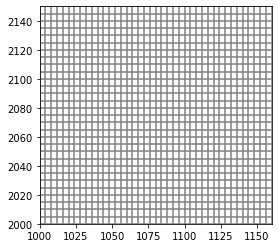

In [5]:
grid = fp.discretization.StructuredGrid(delc,delr,nlay=nlay,xoff=x0,yoff=y0)
grid.plot()

#### Il faut ensuite encore définir les hauteurs des différentes couches. Pour cela on va devoir spécifier un "top" et un "botom" : 
- Top est un simple 2D array de taille (nrow,ncol), il représente l'altitude du top des cellules de la 1ère couche
- botm est un 3D array (si le modèle est multi-couches) de taille : (nlay,nrow,ncol). Il représente l'altitude du botom de chaque cellule

In [1]:
top = 10 # si je ne spéficifie qu'une seule valeur alors elle sera utilisée par défaut
         # sur tout le modèle (i.e. 10*np.ones([nrow,ncol]))
botm = [5,0,-10] # si je ne spéficie que nlay valeurs l'altitude du botom sera appliqué 
                 # à toute la couche correspondante ([botom_lay1,botom_lay2,botom_lay3,...,botom_layn]) très pratique!

#### Ici je définis le sommet du modèle à 10 partout et des couches à 5, 0 et -10 m à la base pour les couches 1,2 et 3 resp.

### Attention !! Modflow vérifie que toutes les cellules aient une épaisseur *a minima* supérieure à 0 sinon une erreur sauvage surgit

On est donc bon à ce niveau pour la discrétisation spatiale. Maintenant on peut un peu complexifier la chose avec la détermination des cellules actives/inactives. Modflow 6 permet ça grâce au *idomain* :
- un array 2D/3D déterminant pour chaque cellule une valeur :
    - -1 : pseudo active, la cellule laisse passer les flux verticaux mais ne participe pas à la simulation autrement
    -  0 : inactive, cellule désactivées et donc imperméables par défaut
    -  1 : active

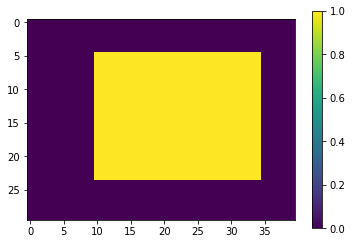

In [7]:
idomain = np.zeros([nlay,nrow,ncol])
idomain[:,5:24,10:35]=1
plt.imshow(idomain[1])
plt.colorbar()

Ci-dessus je définis une zone entre les colonnes 10 et 35, lignes 5 et 24 que je mets comme active (valeur de 1) et ce sur toutes les couches

#### Il est possible d'importer des shapefiles, polygones et de les utiliser pour définir des zones actives/inactives, etc. avec l'outil Gridintersect de flopy

In [8]:
ix = GridIntersect(grid) #

p = Polygon([(1025,2020),(1100,2040),(1110,2130),(1020,2120)]) # création du polygone avec shapely

In [9]:
res = ix.intersect_polygon(p) # on calcule l'intersection

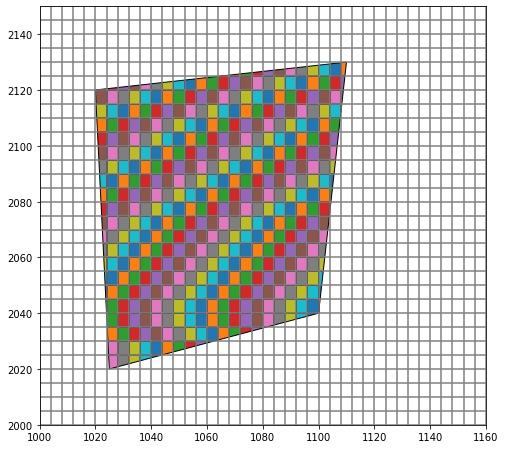

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
grid.plot(ax=ax)
ix.plot_polygon(res, ax=ax)

#### La même chose est possible avec des shapefiles en extrayant les coordonnées des sommets des polygones

#### Pour rendre active la zone à l'intérieur du polygone, on peut simplement extraire les cellids intersectés et itéré dans idomain (par ex.) :

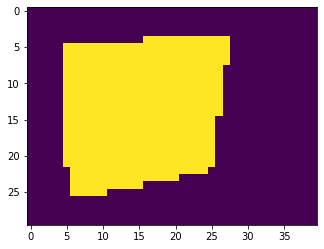

In [11]:
idomain = np.zeros([nlay,nrow,ncol])
for i in res.cellids:
    for ilay in range(nlay): # cette boucle sert à appliquer le changement de idomain sur toutes les couches
        idomain[ilay,i[0],i[1]] = 1
plt.imshow(idomain[0])

### on peut donc maintenant créer notre package dis

In [12]:
# VERY basic modules
model_name="tuto_dis"
model_dir = "workspace"
exe_name = "../../exe/mf6.exe"

sim = fp.mf6.MFSimulation(sim_name='tuto_dis', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))

# on crée le dis package
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,idomain=idomain,xorigin=x0,yorigin=y0)

Remarque : Quand on souhaite changer un package dans flopy (par exemple vous avez modifié la position d'un puit), il est recommandé, voire obligatoire de RE-initialiser également les packages sim et gwf sinon ça ne marchera pas. Flopy vous signalera qu'un package "wel" existe déjà et qu'il va récrire par dessus mais souvent ça plante...

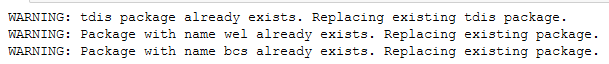


Donc ce que je fais, personnellement, c'est que je mets toutes les packages dans la même cellule jupyter (pas ici c'est pour ça que je le signale)

### Je rajoute quelques packages, conditions limites (charges imposées, puit) pour un joli le modèle :O

In [13]:
# charges imposées à gauche 
lst_chd=[]
for irow in range(5,20):
    cell = (0,irow,5)
    lst_chd.append((cell,10)) # format : lst [(cellid,head)]
    
# à droite
for irow in range(5,20):
    cell = (0,irow,25)
    lst_chd.append(((cell,5))
    
wel_spd=[((2,15,15),-0.007)] # un bon puit, débit en m3/s, format : lst [(cellid,Q)]

#discrétisation temporelle
tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
#solver

ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="simple")
# initial conditions

ic   = fp.mf6.ModflowGwfic(gwf,strt=1)
# output control (fichiers de sortie)
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),#nom du fichier budget (ne pas changer)
                            head_filerecord='{}.hds'.format(model_name),# nom du fichier des charges (ne pas changer)
                            saverecord=[('HEAD', 'LAST'), 
                                        ('BUDGET', 'LAST')],
                            printrecord=[('BUDGET', 'ALL')])

# nodeflowproperty (conductivité, flux à enregistrer, ...)
k = [1e-4,1e-6,1e-4] # perméabilité des couches, par couche
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k,save_flows=True,save_specific_discharge=True)

#initialise les puits
wel = fp.mf6.ModflowGwfwel(gwf,pname="wel",maxbound=len(wel_spd),stress_period_data=wel_spd,save_flows=True)

#initialise les charges imposées
chd = fp.mf6.ModflowGwfchd(gwf,pname="BCs",maxbound=len(lst_chd),stress_period_data={0:lst_chd},save_flows=True)

In [14]:
#créer les fichiers et runer le tout
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model tuto_dis...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package wel...
    writing package bcs...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 


(True, [])

## Visualisation

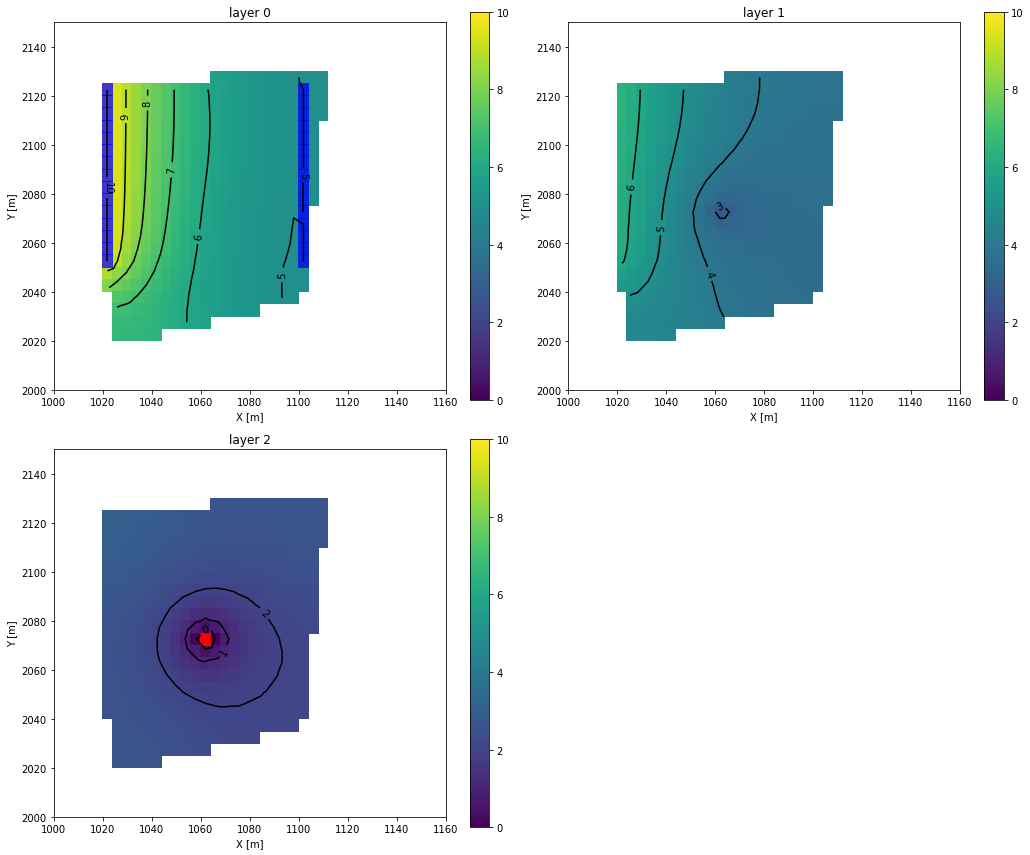

In [40]:
#récupération des données
head = get_heads(model_name,model_dir)
spdis = get_spdis(model_name,model_dir)

# on initialise une figure
fig = plt.figure(figsize=(18,15))
fig.subplots_adjust(wspace=0.05,hspace=0.1)
# on itère à chaque couche
for layer in range(3):
    ax  = fig.add_subplot(2,2,layer+1, aspect='equal')
    ml = fp.plot.PlotMapView(model=gwf,layer=layer)
    hmesh=ml.plot_array(head[layer],masked_values=[0,1e30],cmap="viridis")
    hmesh.set_clim(0,10)
    
    #plot contour
    cont = ml.contour_array(head[layer],masked_values=[0,1e30],levels=np.linspace(0,10,11),colors="black")
    plt.clabel(cont,fmt="%1i")  
    
    #plot bc 
    ml.plot_bc("wel")
    ml.plot_bc("Bcs",color="blue",alpha=0.5)
    
    #set labels
    plt.title("layer {}".format(layer))
    plt.colorbar(hmesh)
    plt.xlabel("X [m]")
    plt.ylabel("Y [m]")

On peut également réaliser des coupes pour voir les variations verticales (avec PlotCrossSection)

(10, 113)

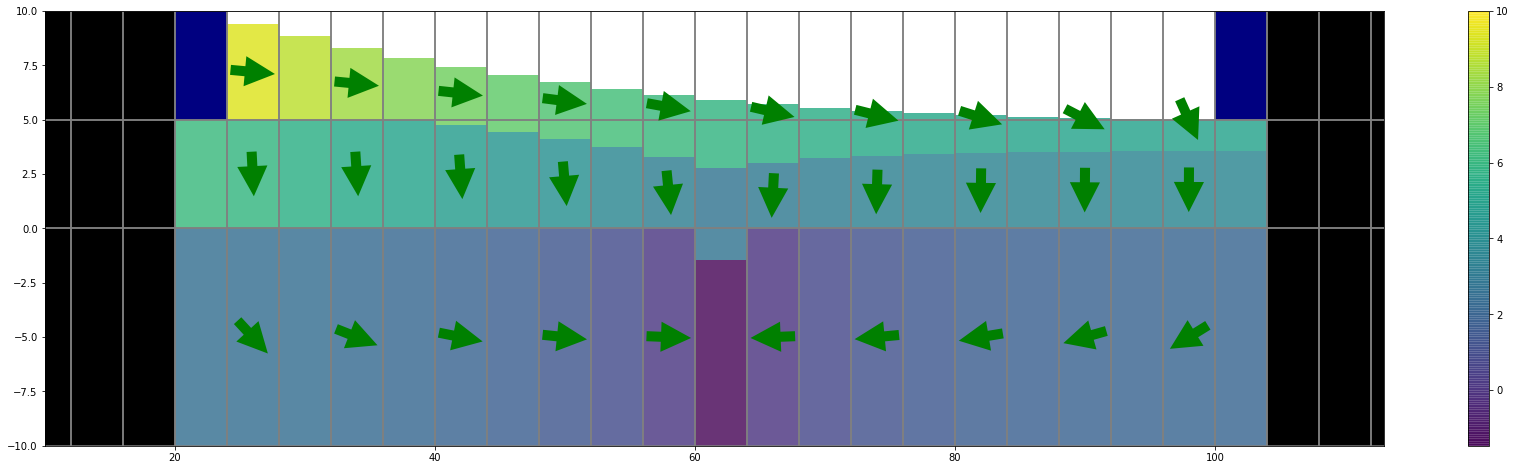

In [16]:
fig,ax = plt.subplots(figsize=(30,8))
x=fp.plot.PlotCrossSection(gwf,line={"row" :15})# on définit à quelle ligne/colonne on veut faire la coupe

arr=x.plot_array(head,masked_values=[1e30],head=head,alpha=0.8)
plt.colorbar(arr)
x.plot_ibound()
x.plot_grid()
x.plot_bc("chd")
quiver = x.plot_specific_discharge(spdis, head=head, 
                                       hstep=2, normalize=True, color='green', 
                                       scale=30, headwidth=3, headlength=3, headaxislength=3,
                                       zorder=10)
ax.set_xlim(10,113)

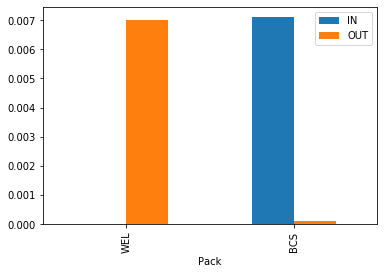

In [46]:
get_Total_Budget(model_name,model_dir).set_index("Pack").plot(kind="bar")